In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import streamlit as st

def rmse(y_true, y_pred):
    return np.sqrt(
        mean_squared_error(
            y_true, 
            y_pred, 
            squared=False))

# Load Data

In [2]:
train = pd.read_csv('train-air-qual-preprocessed.csv', parse_dates=['Date_Time'], index_col=['Date_Time'])
test = pd.read_csv('test-air-qual-preprocessed.csv', parse_dates=['Date_Time'], index_col=['Date_Time'])

train.shape, test.shape

((7359, 36), (727, 36))

# Separate into train and test

- We will train the model on a certain portion of the data and leave another part out to evaluate the model
- Because these are time series, I will split based on time. We leave the most recent data as test set.

In [3]:
# Find minimum and maximum dates.

train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2004-04-05 00:00:00'),
 Timestamp('2005-03-04 00:00:00'),
 Timestamp('2005-03-05 01:00:00'),
 Timestamp('2005-04-04 14:00:00'))

In [4]:
# We will keep the last month of the test
# the forecasting models.

X_train = train[train.index <= "2005-03-04"]
X_test = test[test.index > "2005-03-04"]

X_train.shape, X_test.shape

((7359, 36), (727, 36))

In [5]:
# the target variable
y_train = X_train["CO_sensor"].copy()
y_test = X_test["CO_sensor"].copy()

# remove raw time series from predictors set
X_train = X_train.drop("CO_sensor", axis=1)
X_test = X_test.drop("CO_sensor", axis=1)

In [6]:
X_train.head()

,month,week,day,day_of_year,day_of_week,hour,is_weekend,CO_sensor_lag_1,RH_lag_1,CO_sensor_lag_24,...,CO_sensor_lag_19_y,RH_lag_19_y,CO_sensor_window_mean_5,RH_window_mean_5,CO_sensor_window_std_5,RH_window_std_5,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,,,,,,,,,
2004-04-05 00:00:00,4,15,5,96,0,0,0,1188.0,60.8,1224.0,...,1010.0,66.5,1256.6,53.84,130.064599,6.854415,0.866025,-0.5,0.000000,1.000000
2004-04-05 01:00:00,4,15,5,96,0,1,0,1102.0,64.4,1215.0,...,1074.0,69.1,1193.0,57.80,105.645634,5.823659,0.866025,-0.5,0.269797,0.962917
2004-04-05 02:00:00,4,15,5,96,0,2,0,969.0,63.3,1115.0,...,1034.0,64.8,1113.6,60.68,91.336192,3.362588,0.866025,-0.5,0.519584,0.854419
2004-04-05 03:00:00,4,15,5,96,0,3,0,983.0,61.5,1124.0,...,1130.0,59.0,1087.6,61.76,108.449527,2.184720,0.866025,-0.5,0.730836,0.682553
2004-04-05 04:00:00,4,15,5,96,0,4,0,876.0,56.9,1028.0,...,1275.0,49.8,1023.6,61.38,122.054496,2.882187,0.866025,-0.5,0.887885,0.460065


# Naive Forecast

- We will predict pollutants concentration at time t with its value at time t-1
- We will use this model as a benchmark

In [7]:
# Performance if naive forecast

print('train rmse', rmse(
    y_train, X_train['CO_sensor_lag_1']))

print('test rmse', rmse(
    y_test, X_test['CO_sensor_lag_1']))

train rmse 10.079549839990316
test rmse 10.194134980602554


# Random Forests

In [8]:
rf_model = RandomForestRegressor(
    n_estimators=90,
    max_depth=12,
    random_state=32
)
rf_model.fit(X_train, y_train)

p_train = rf_model.predict(X_train)
p_test = rf_model.predict(X_test)

# Performance of random forests
print('train rmse: ', rmse(y_train, p_train))
print('test rmse: ', rmse(y_test, p_test))
print()

train rmse:  6.259441755732381
test rmse:  8.656626493945623



# Lasso

In [9]:
rf_model = Lasso(
    random_state=32
)
rf_model.fit(X_train, y_train)

p_train = rf_model.predict(X_train)
p_test = rf_model.predict(X_test)

# Performance of random forests
print('train rmse: ', rmse(y_train, p_train))
print('test rmse: ', rmse(y_test, p_test))
print()

train rmse:  9.269132321426962
test rmse:  9.14698864542554



# XGBoost

In [14]:
rf_model = XGBRegressor(
    n_estimators=50,
    max_depth=4,
    random_state=32
)
rf_model.fit(X_train, y_train)

p_train = rf_model.predict(X_train)
p_test = rf_model.predict(X_test)

# Performance of random forests
print('train rmse: ', rmse(y_train, p_train))
print('test rmse: ', rmse(y_test, p_test))
print()

train rmse:  7.838339563690127
test rmse:  8.72585664803337



In [11]:
# Performance of random forests
print('train rmse: ', rmse(y_train, p_train))
print('test rmse: ', rmse(y_test, p_test))

train rmse:  7.838339563690127
test rmse:  8.72585664803337



- Naive Forecast:
- train rmse:  10.384540881680582
- test rmse:  10.436107388051472

- Random Forest
- train rmse:  9.941812950363632
- test rmse:  10.04534806456162

# Understanding the predictions on a plot

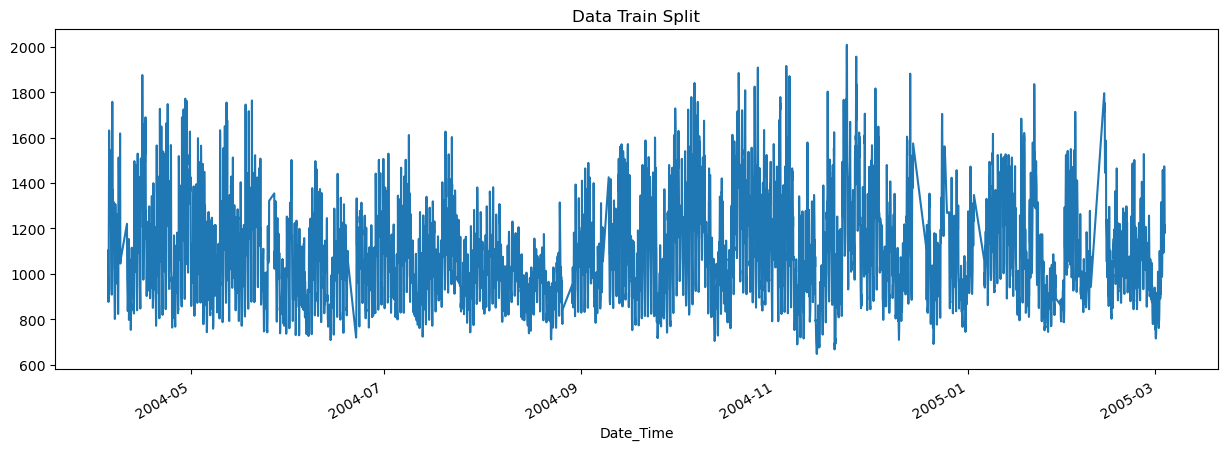

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))
train['CO_sensor'].plot(ax=ax, label='Training Set', title='Data Train Split')
plt.show()

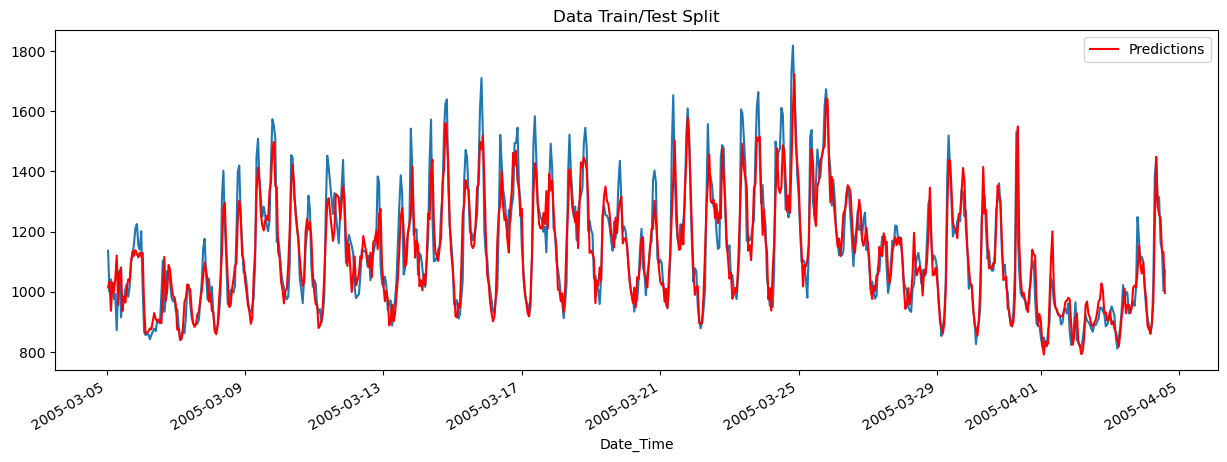

In [17]:
pred = y_test.copy()
#pred['Predictions'] = p_test
pred = pd.DataFrame(pred)
pred['Predictions'] = p_test
pred = pred.drop(columns=['CO_sensor'])
#pred = pred.set_index('Date_Time')
#pred['CO_sensor'].plot()
# Makes it convenient to create common layouts of subplots, including the enclosing figure object, in a single call.
fig, ax = plt.subplots(figsize=(15, 5))
y_test.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
pred.plot(ax=ax, label='Validation Set', color='red')
#pred.plot(ax=ax, label='Predictions')
# Line to divide between the "training" and "validadion"
#ax.axvline('2005-03-04', color='black', ls='--')
# Setting the legend.
#ax.legend(['Training Set', 'Test Set'])
plt.show()